# 2. 4-qubit 1D XY-model in a z-axis Magnetic Field

In [27]:
import pennylane as qml
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import numpy as np
from numpy import array
import scipy
from scipy.optimize import minimize
import networkx as nx
import itertools
from numpy import savetxt
from numba import jit, cuda
import seaborn
from IPython.display import Image

np.random.seed(42)

In this section, we studied 1D XY-model in a z-axis magnetic field. The Hamiltonian of this system is:

### $$H=\sum_{<i,j>} (X_{i} \otimes X_{j}+Y_{i} \otimes Y_{j})+h\sum_{i}Z_{i}$$

where Xi, Yi, Zi denotes the Pauli_X, Pauli_Y, Pauli_Z gate of i-th qubit, respectively. h is strength of the external magnetic field. In this study, we set the number of qubits to 4. According to the Ref. [1], the study of 4-qubit system is equivallent to that of 2^4-qubit system. So we expect that we can investigate most of important properties of the system using 4 qubits.

In [4]:
nr_qubits=4

The interaction between qubits can be represented by following interaction picture.

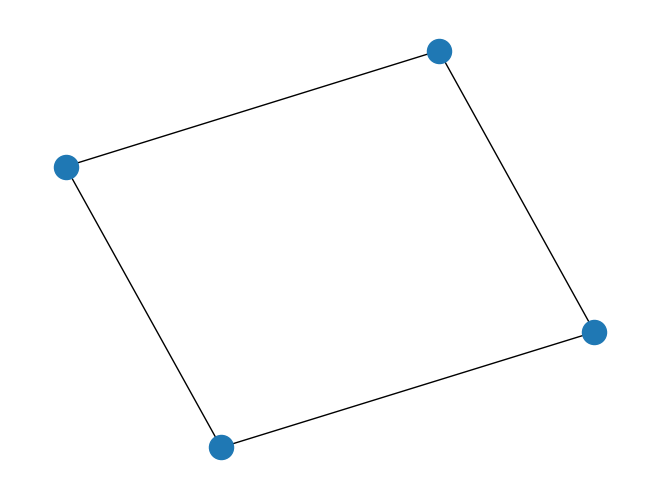

In [5]:
# Interaction Picture

interaction_graph = nx.cycle_graph(nr_qubits)
nx.draw(interaction_graph)

In [6]:
interaction_graph.edges

EdgeView([(0, 1), (0, 3), (1, 2), (2, 3)])

Therefore, we can compose the Hamiltonian using following code.

In [9]:
# Creating Hamiltonian matrix

def create_hamiltonian_matrix(n, h, graph):
    matrix = np.zeros((2 ** n, 2 ** n))
    for i in graph.edges:
        x = y = 1
        for j in range(0, n):
            if j == i[0]:
                x = np.kron(x, qml.matrix(qml.PauliX)(0))
                y = np.kron(y, qml.matrix(qml.PauliY)(0))
                
            elif j == i[1]:
                x = np.kron(x, qml.matrix(qml.PauliX)(0))
                y = np.kron(y, qml.matrix(qml.PauliY)(0))
                
            else:
                x = np.kron(x, np.identity(2))
                y = np.kron(y, np.identity(2))
            
        matrix = np.add(matrix, np.add(x, y))

    for i in range(0, n):
        z = 1
        for j in range(0, n):
            if j == i:
                z = np.kron(z, qml.matrix(qml.PauliZ)(0))           
                
            else:
                z = np.kron(z, np.identity(2))
                
        matrix = np.add(matrix, h*z) 
        
    return matrix

For example, for the case h=-1, we can visualize the Hamiltonian like:

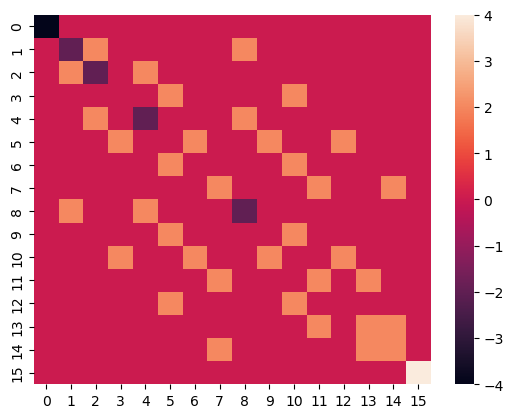

In [10]:
h=-1
ham_matrix=create_hamiltonian_matrix(nr_qubits, h, interaction_graph)

# Prints a visual representation of the Hamiltonian matrix
seaborn.heatmap(ham_matrix.real)
plt.show()

To analyze the system, we should calculate the thermal state of the system. Thermal is defined as:

### $$ \rho =\frac{e^{-\beta H}}{Z}$$

where $Z=Tr(-\beta H)$, $\beta=\frac{1}{T}$. Thermal state can be calculated using following code:

In [13]:
# Matrix representation of the thermal state

def create_target(qubit, beta, ham, b, graph):

    # Calculates the matrix form of the density matrix by taking the exponential of the Hamiltonian

    h = ham(qubit, b, graph)
    y = -1 * float(beta) * h
    new_matrix = scipy.linalg.expm(np.array(y))
    norm = np.trace(new_matrix)
    final_target = (1 / norm) * new_matrix

    return final_target

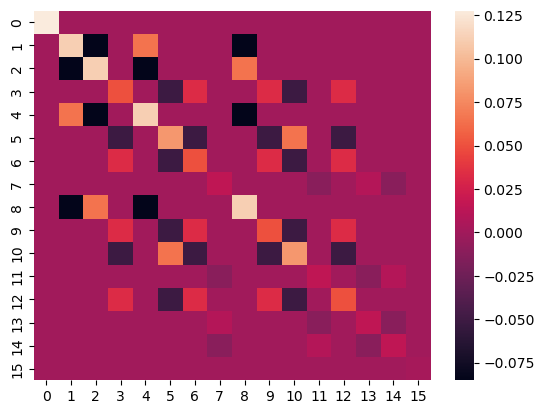

In [15]:
h=-1
beta=0.5

# Prints a visual representation of the thermal state
seaborn.heatmap(create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph).real)
plt.show()

Before go futher, we compose the 'magnetization matrix' which represents Pauli_Z gate of 1st qubit.

In [16]:
# Composing magnetization matrix

M_matrix = 1
for i in range(nr_qubits):
    if i==0 :
        M_matrix = np.kron(M_matrix, qml.matrix(qml.PauliZ(0)))
    else :
        M_matrix = np.kron(M_matrix, np.identity(2)) 

From now on, we will calculate the energy curve and the magnetization curve (which represents expectation value of M_matrix) of the system. We accomplished this using the code like:

In [18]:
# Calculating the energy curve and the magnetization curve

h=-1
beta_list = [1/t for t in np.linspace(0.01,100,100)]
beta_list.sort()
T = [1/beta for beta in beta_list]

exactenergy_list1_ = []
magnetization_list1_=[]
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, h, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, h, interaction_graph)
    exactenergy = np.trace(np.matmul(hamiltonian, target_density_matrix))
    magnetization = np.trace(np.matmul(M_matrix, target_density_matrix))
    exactenergy_list1_.append(exactenergy)
    magnetization_list1_.append(magnetization)
    
NCE1_=[]
NCM1_=[]
for i in exactenergy_list1_ :
    NCE1_.append(i.real)
for i in magnetization_list1_ :
    NCM1_.append(i.real)

For the above example, we can obtain the energy curve and the magnetization curve like:

Text(0, 0.5, 'E [a.u.]')

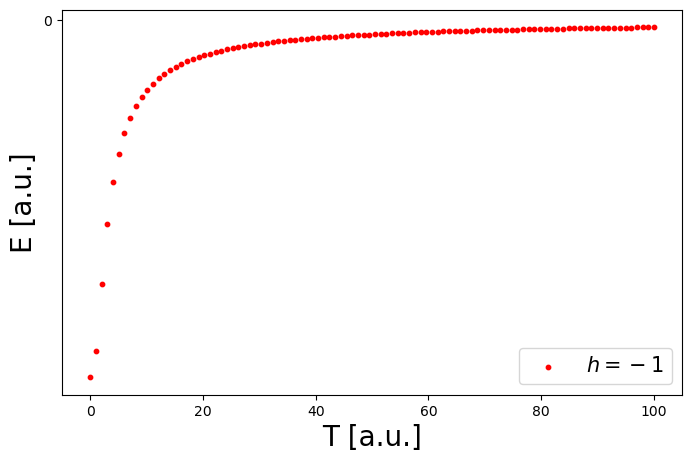

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

ax.scatter(T, NCE1_, s=10, c='red', label=r'$h=-1$')

ax.legend(loc='lower right', fontsize=15)

ax.set_xlabel('T [a.u.]',fontsize=20)
ax.set_ylabel('E [a.u.]',fontsize=20)

Text(0, 0.5, 'M [a.u.]')

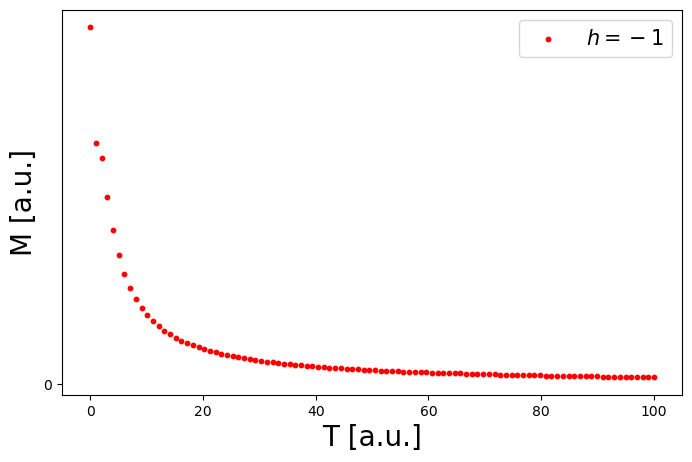

In [25]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

ax.scatter(T, NCM1_, s=10, c='red', label=r'$h=-1$')

ax.legend(loc='upper right', fontsize=15)

ax.set_xlabel('T [a.u.]',fontsize=20)
ax.set_ylabel('M [a.u.]',fontsize=20)

For various values of h, we obtained the energy curve like:

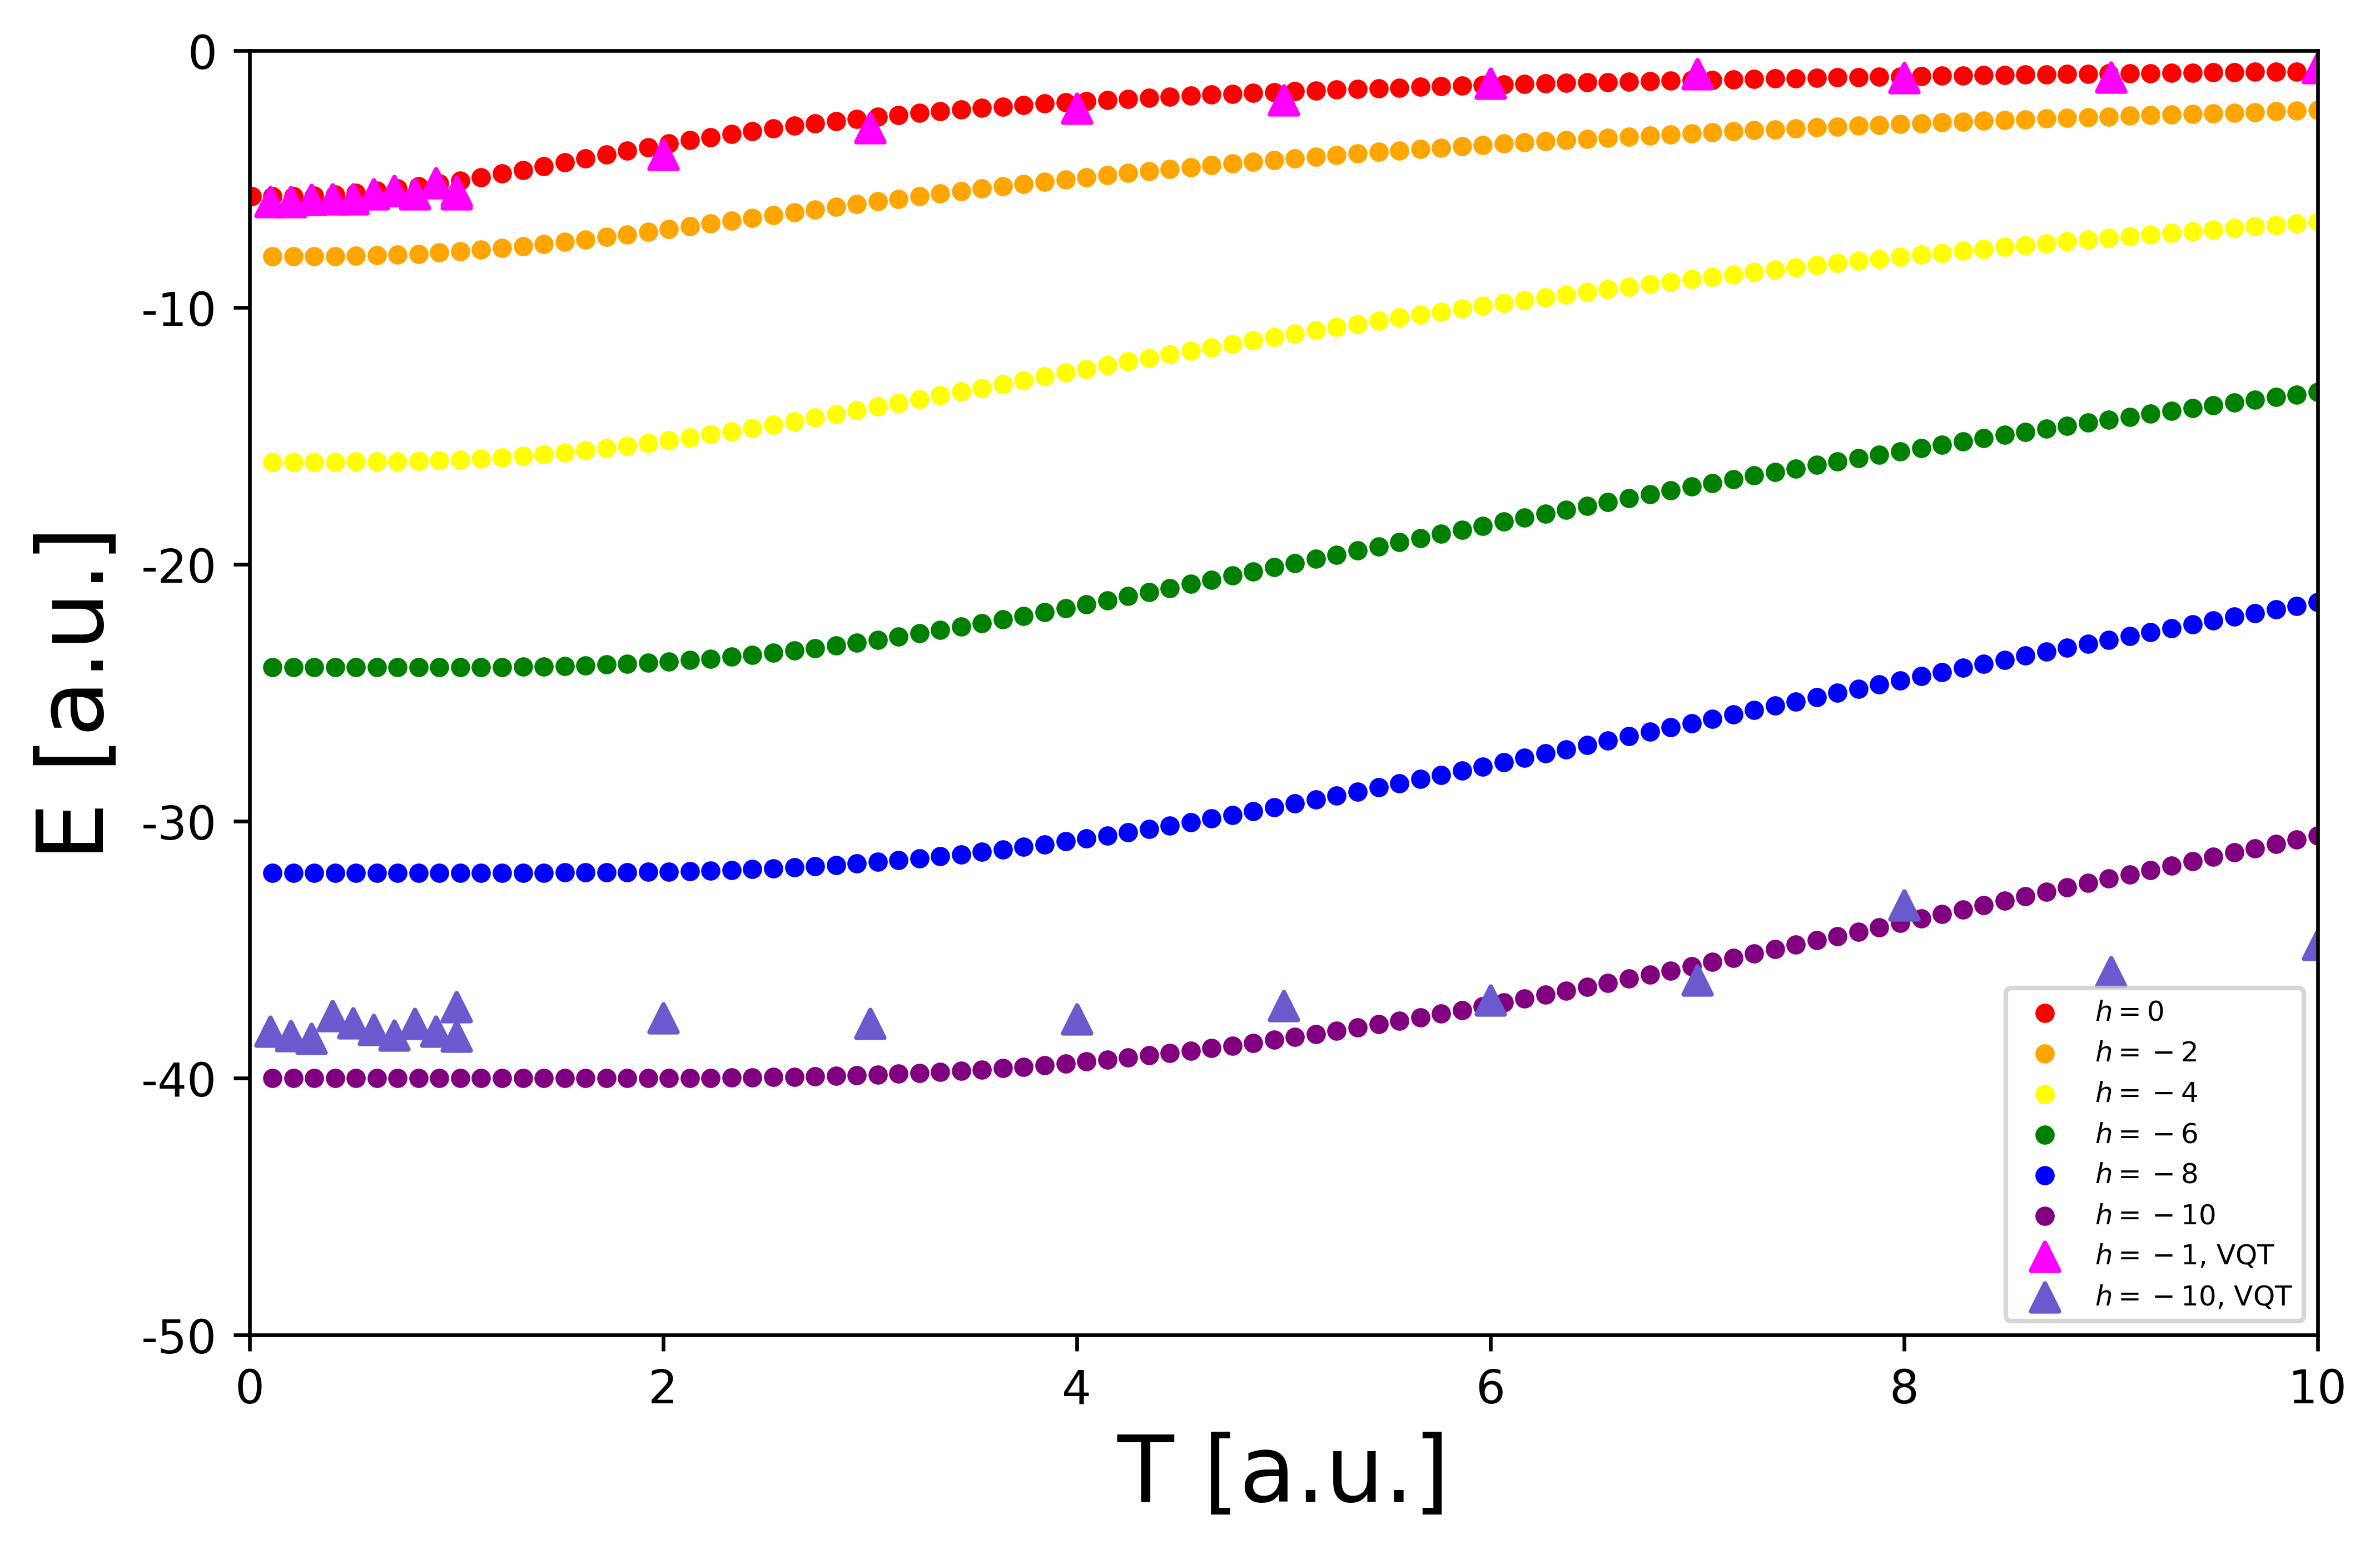

In [29]:
Image("C:/Users/user/Desktop/SQRT/2023 QHack/Energy Curve.png")

In the energy curve, the triangles represent the results of VQT method. We can easily notice that the VQT results are quite well fitted with the exact calculation. Because the VQT takes a lot of time, we only used exact calculation method for futher analysis.

Also, we obtained the magnetization curve like:

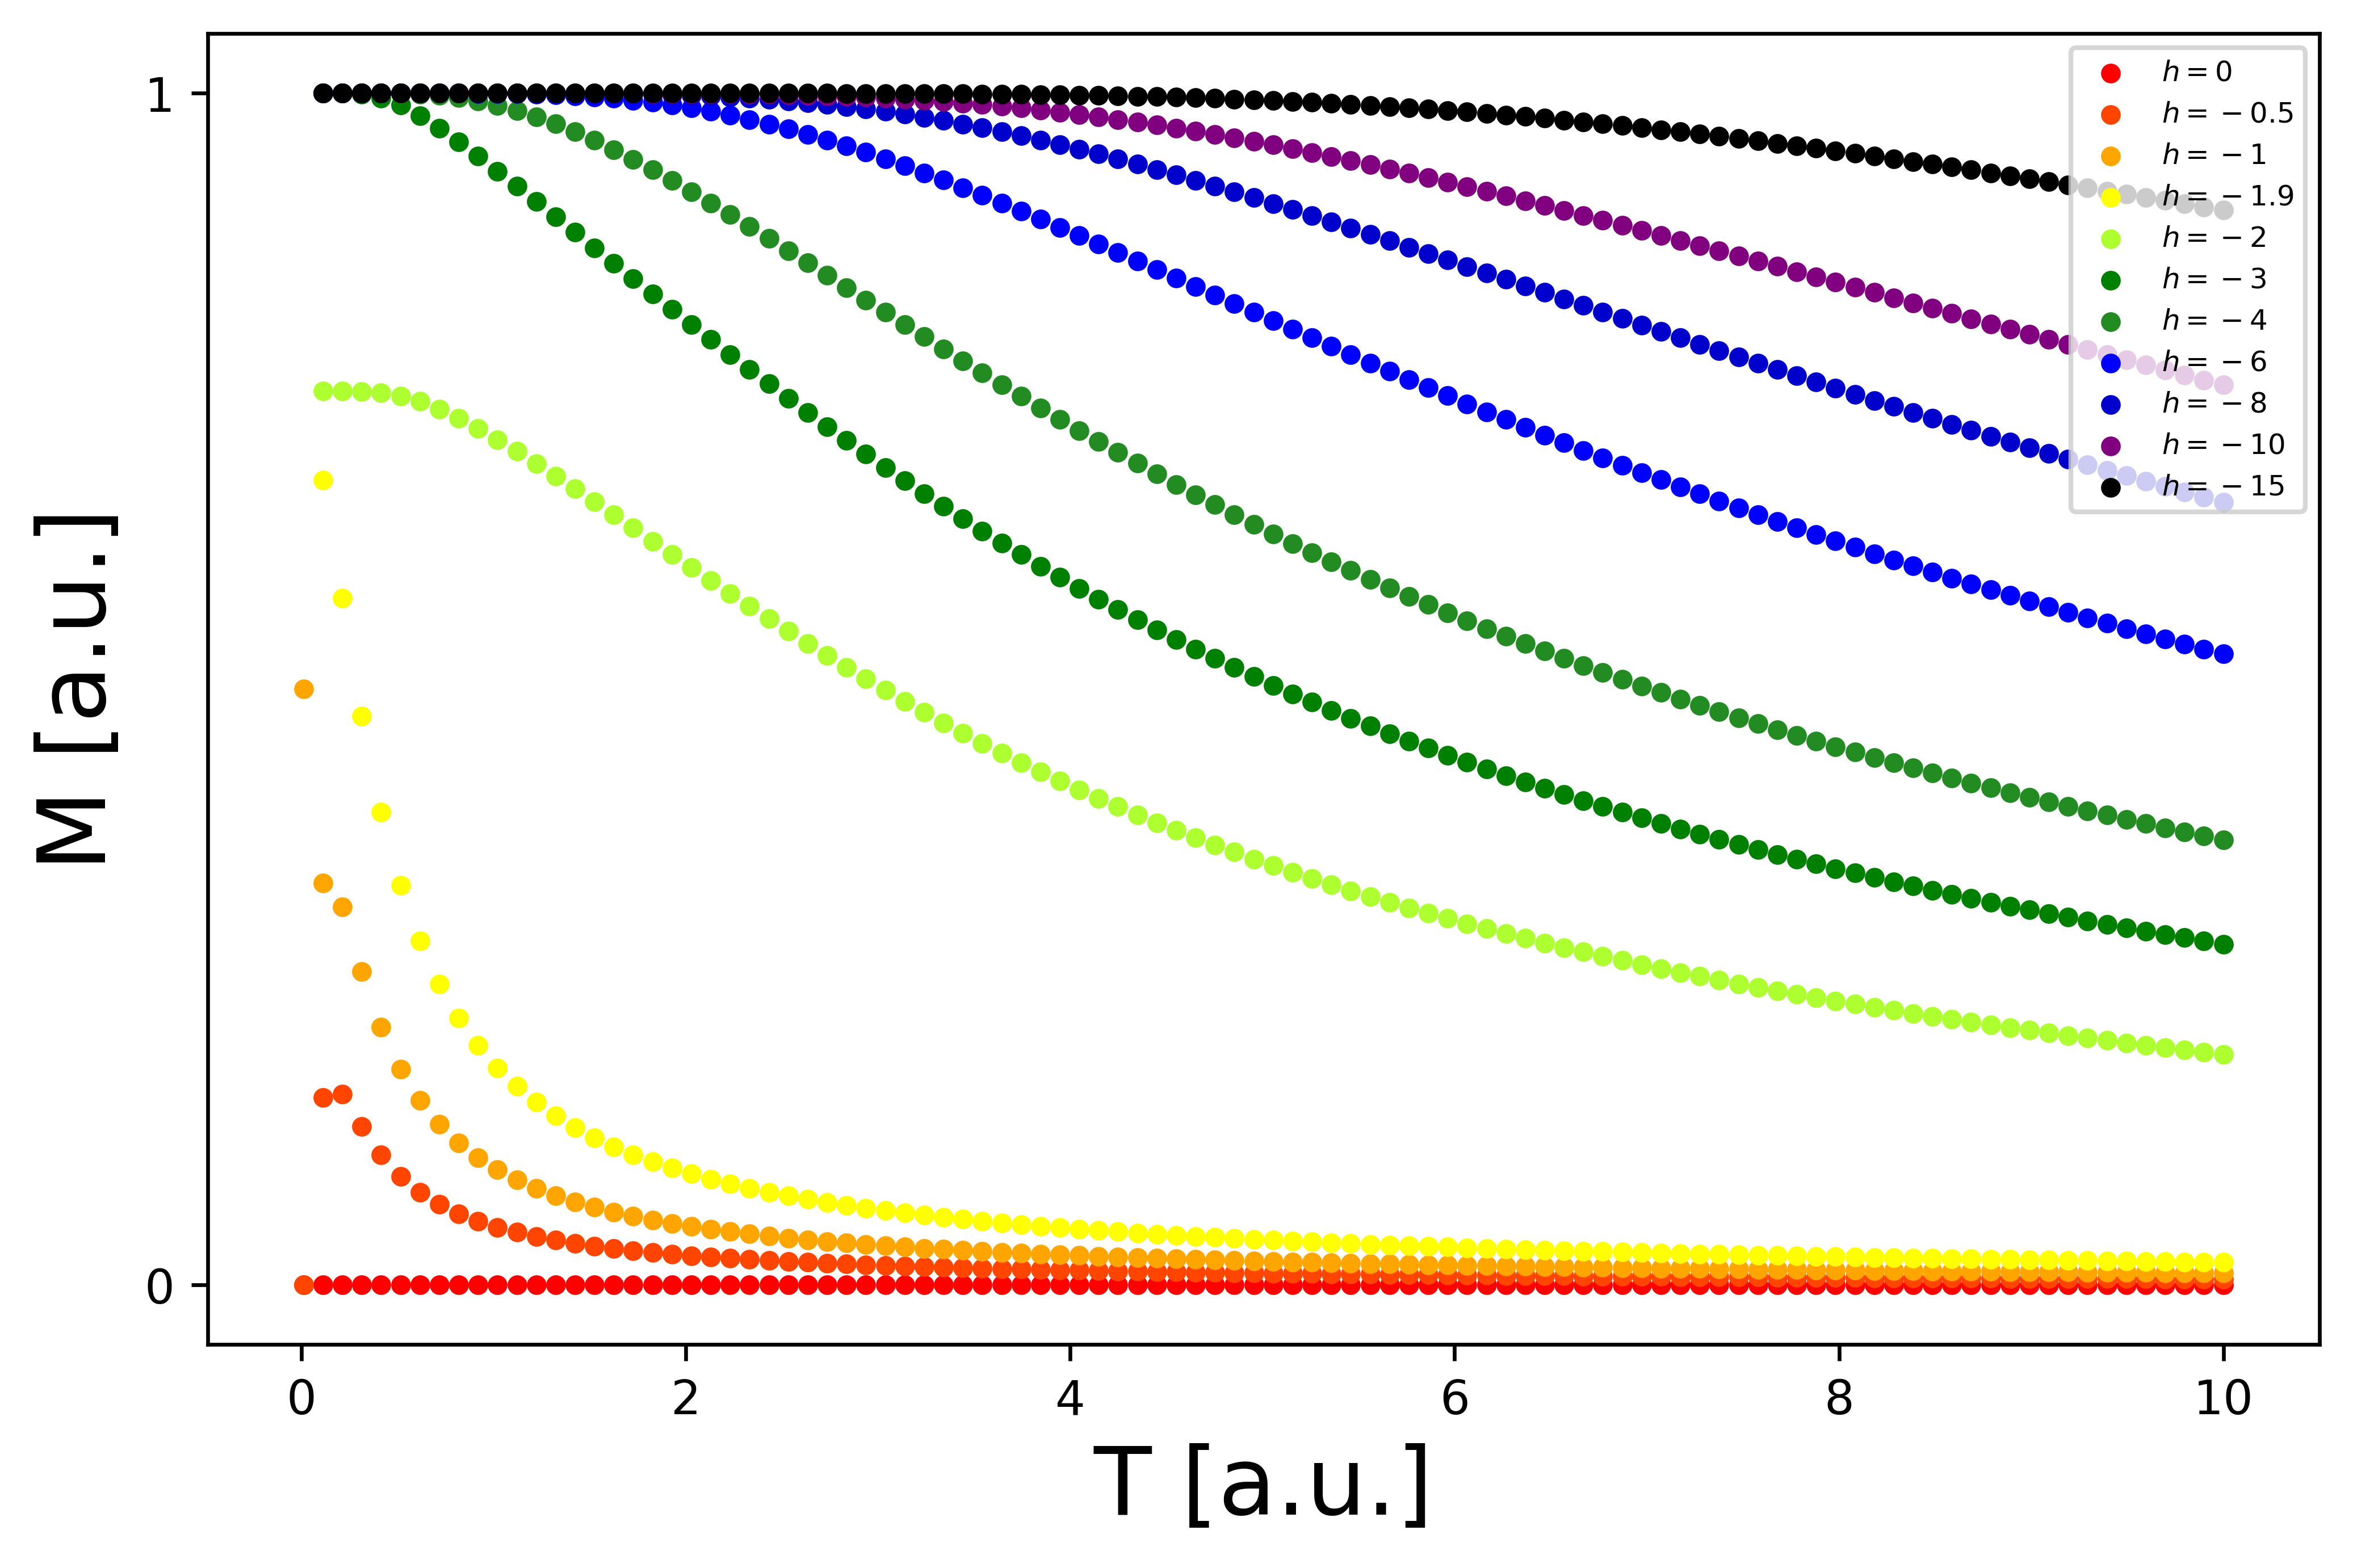

In [30]:
Image("C:/Users/user/Desktop/SQRT/2023 QHack/Magnetization Curve.png")

The shape of this curve is similar to the one in the below from Ref. [2] which studied the same system. So we can conclude our analysis is valid.

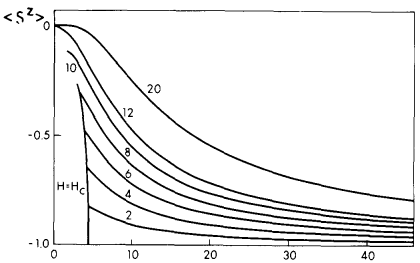

In [34]:
Image("C:/Users/user/Desktop/SQRT/2023 QHack/Magnetization Curve from Paper.png")

By numerically differentiating the energy curve, we obtained the specific heat curve like:

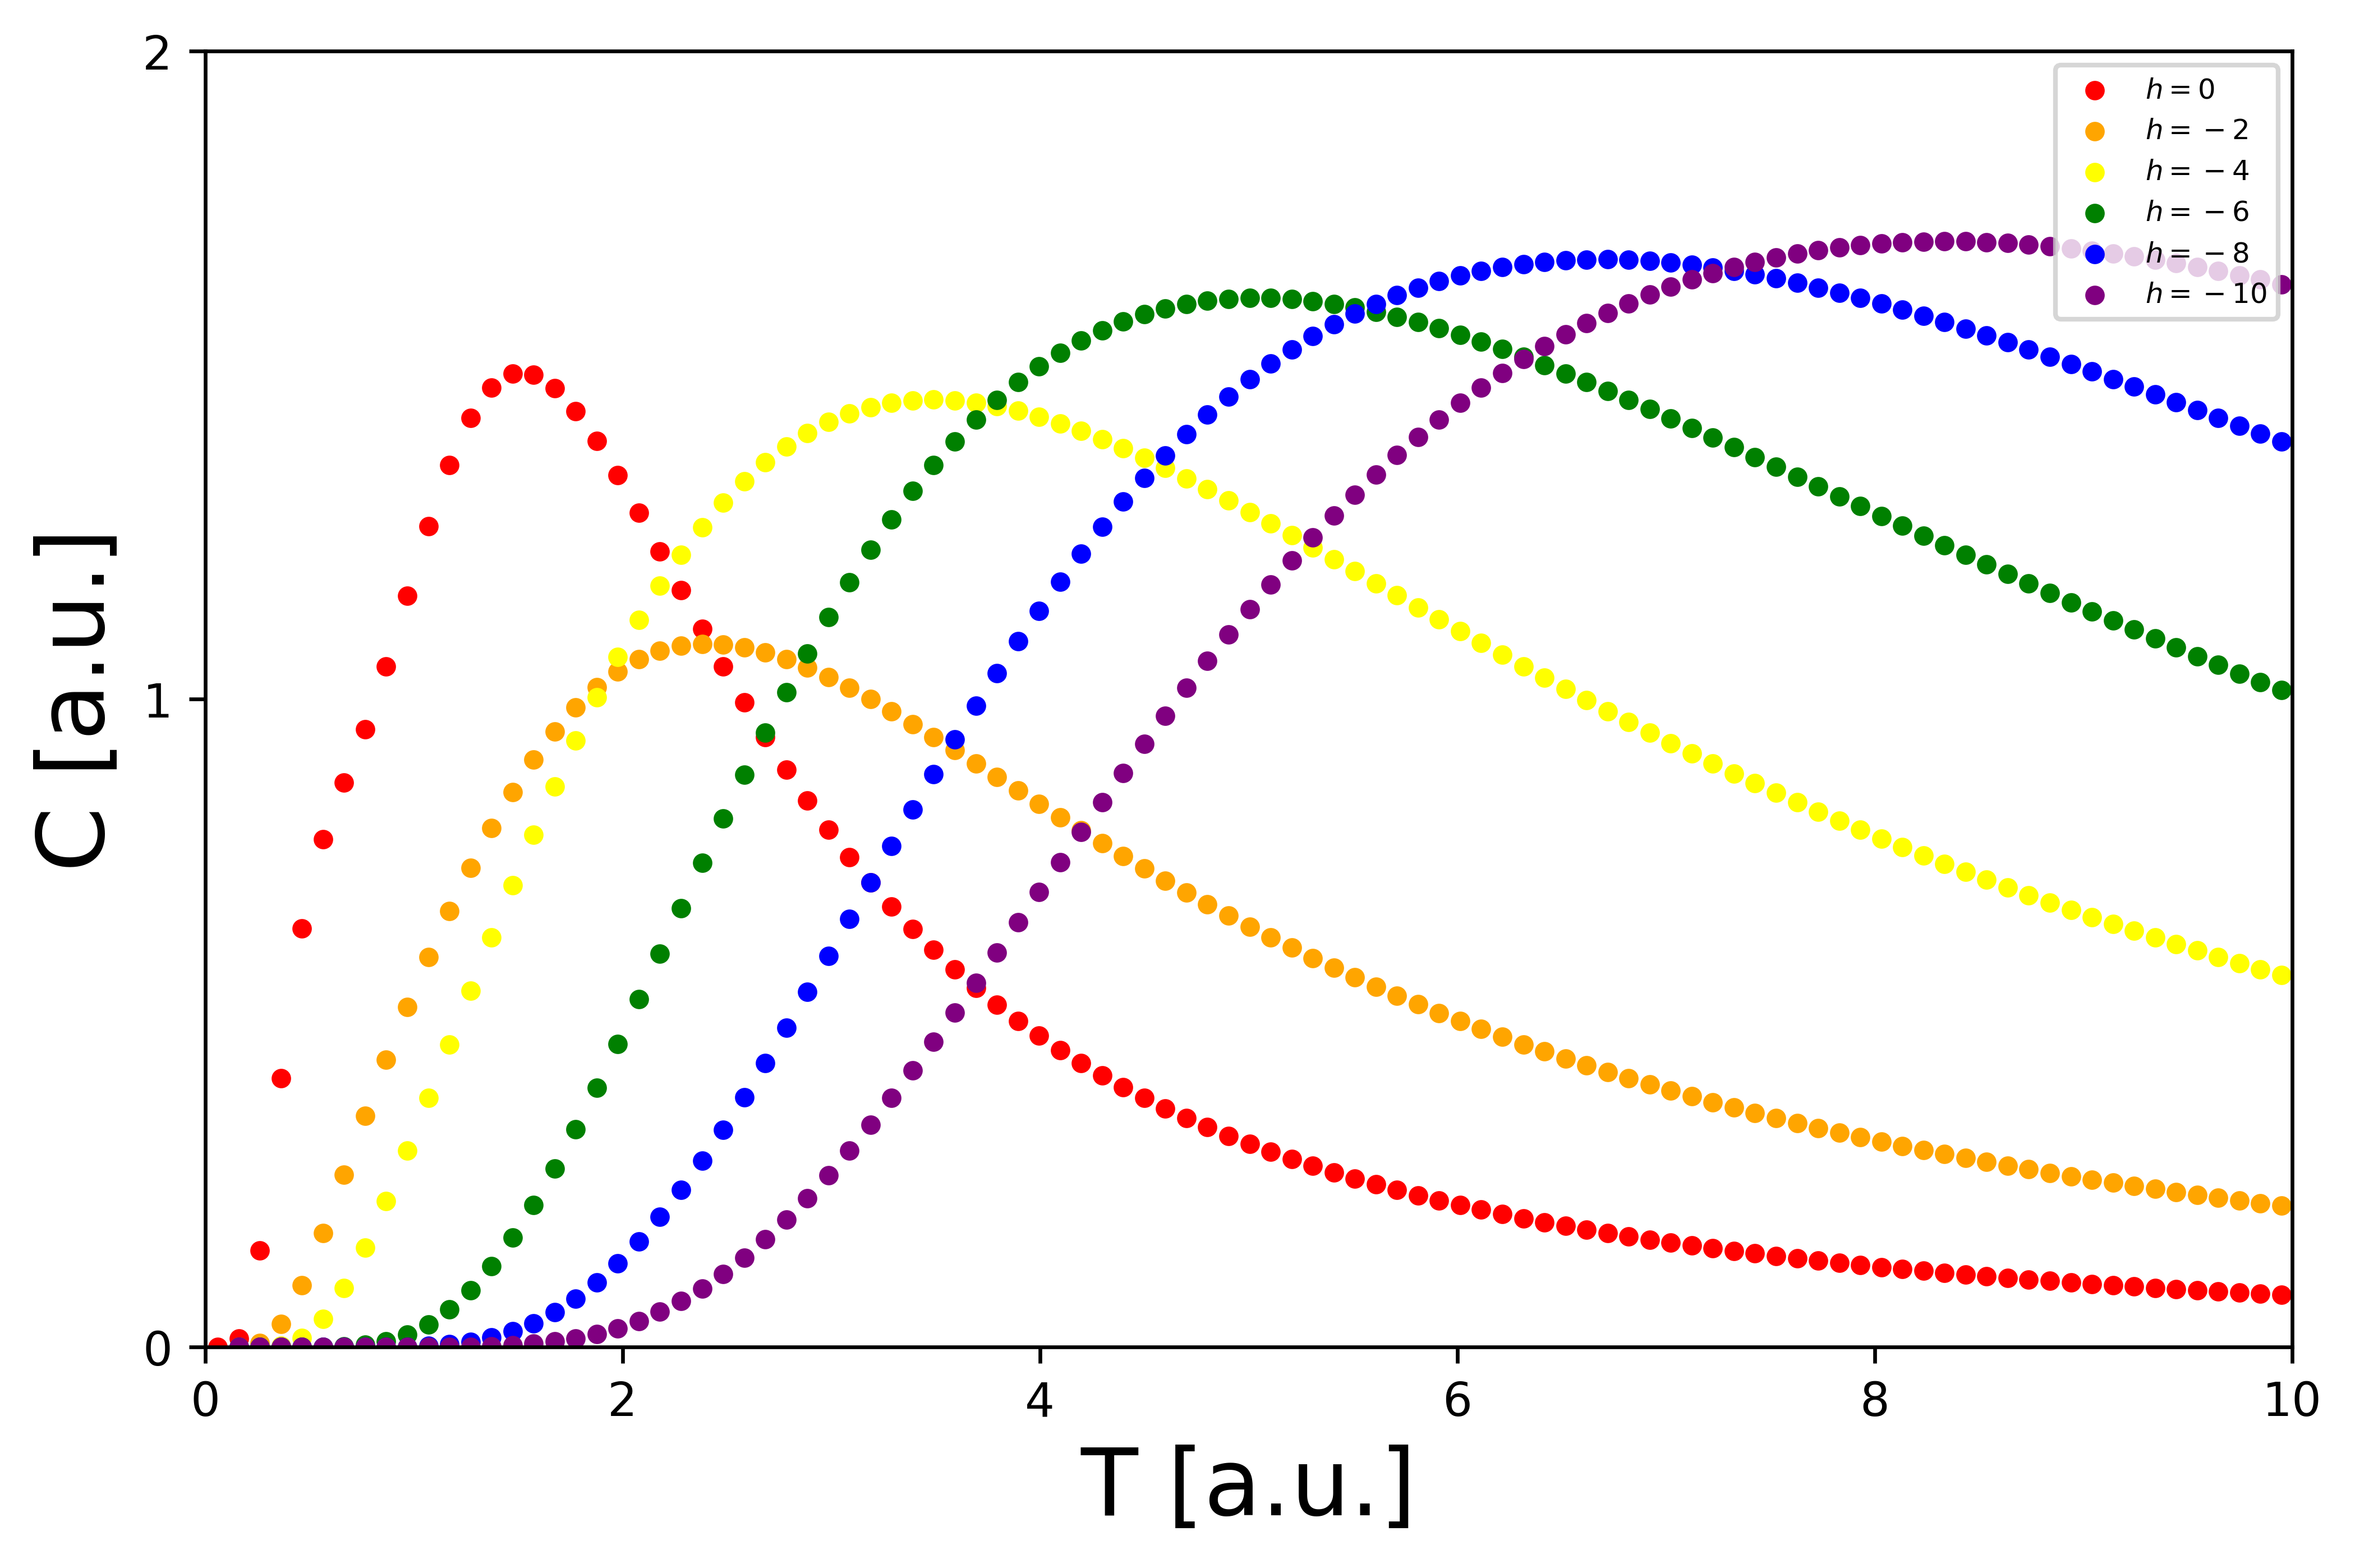

In [33]:
Image("C:/Users/user/Desktop/SQRT/2023 QHack/Specific Heat Curve.png")

In the specific heat curve, there is one peak for each curves. According to the Ref. [3], each peaks seem to be Berezinski-Kosterlitz-Thouless transition points. Because this transition is related with topological defects, it is hard to analyze this phenomenon in this study. We won't go futher about this in our study. Instead, we will investigate another phase transition. We used M as order parameter, and finally obtained the graph below. 

In [39]:
Image("C:/Users/user/Desktop/SQRT/2023 QHack/Order Parameter Graph (Magnetization).png")

(a) T ~ 0.2, (b) T ~ 0.5, (c) T ~ 2.0, (d) T ~ 5.0

We can see that at $h=2$, regardless of temperature, there is a first order transition where M increases discontineously. We can also see this transition in terms of the observable 'XY'

$$XY=X_{1} \otimes X_{2}+Y_{1} \otimes Y_{2}$$

To see this, we compose XY matrix which represents this gate.

In [37]:
# Composing XY matrix

XY_matrix = 0
x = y = 1
for i in range(0, nr_qubits):
    if i == 0:
        x = np.kron(x, qml.matrix(qml.PauliX)(0))
        y = np.kron(y, qml.matrix(qml.PauliY)(0))
                
    elif i == 1:
        x = np.kron(x, qml.matrix(qml.PauliX)(0))
        y = np.kron(y, qml.matrix(qml.PauliY)(0))
                
    else:
        x = np.kron(x, np.identity(2))
        y = np.kron(y, np.identity(2))
            
XY_matrix = np.add(XY_matrix, np.add(x, y))

Using expectation value of XY as order parameter, we obtained the graph below. 

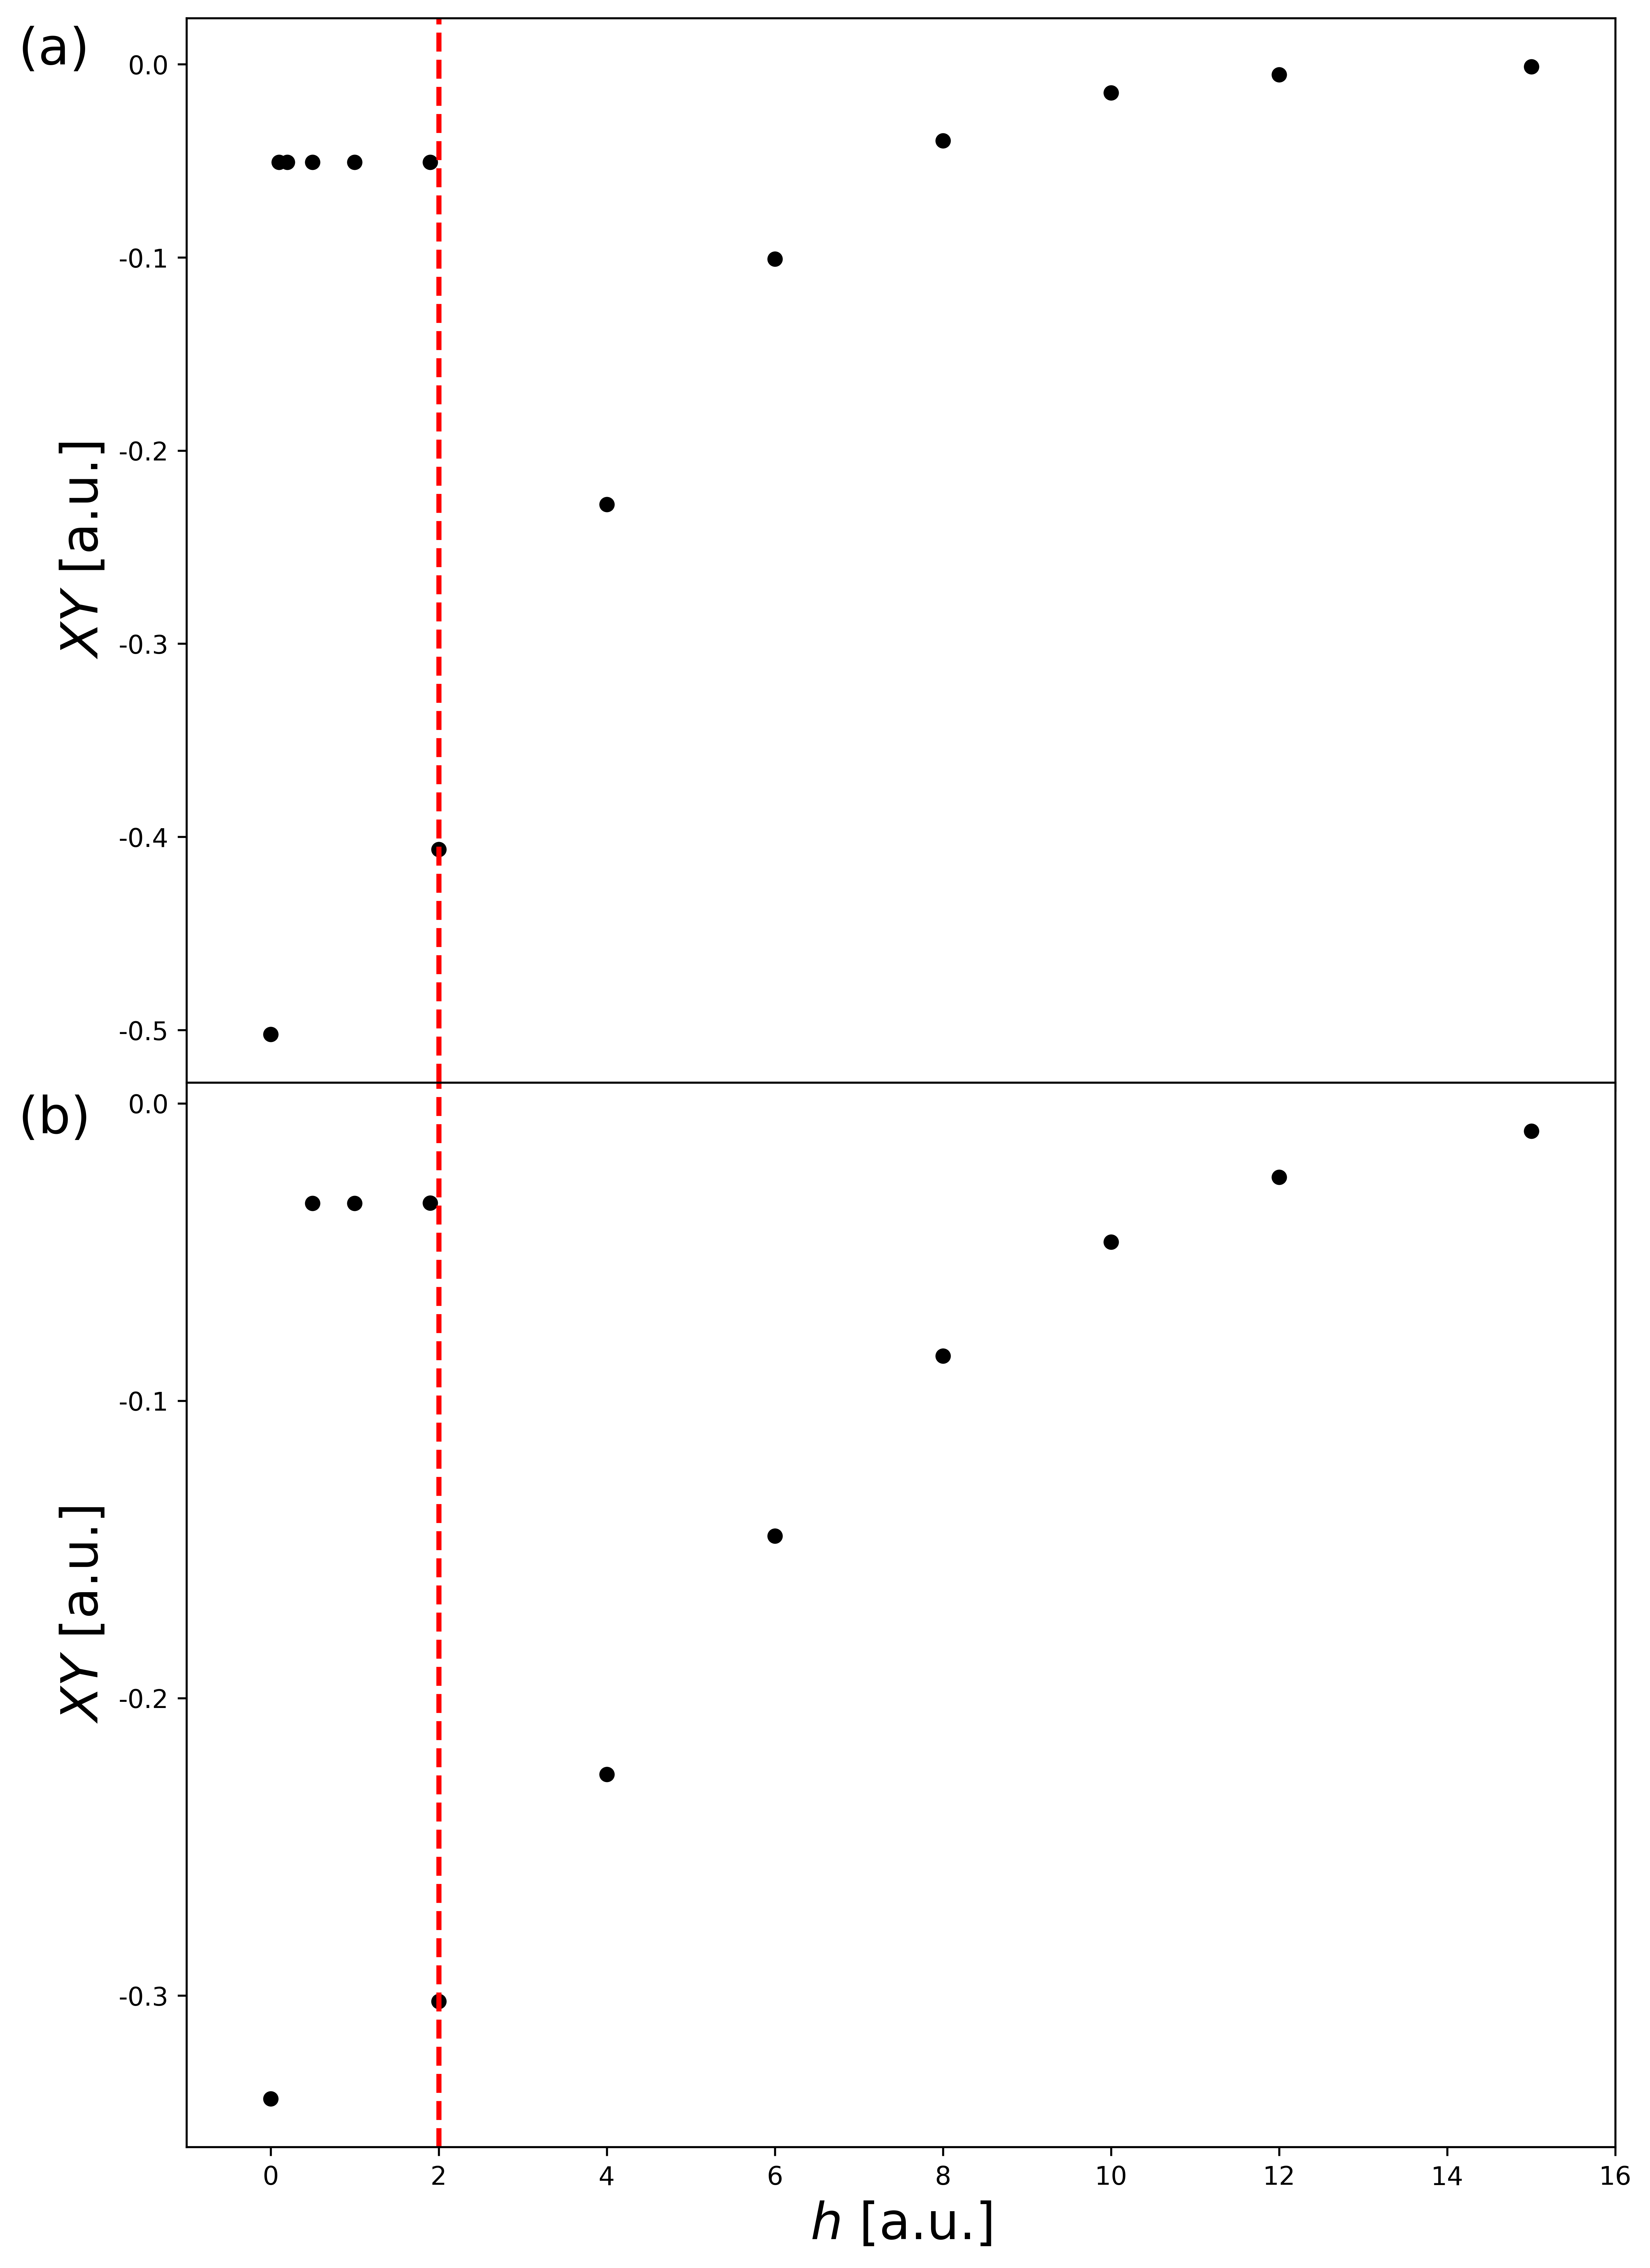

In [40]:
Image("C:/Users/user/Desktop/SQRT/2023 QHack/Order Parameter Graph (XY).png")

We can see that at $h=2$, regardless of temperature, there is a first order transition where XY drops abruptly.

So, the skematic phase diagram of this system is:

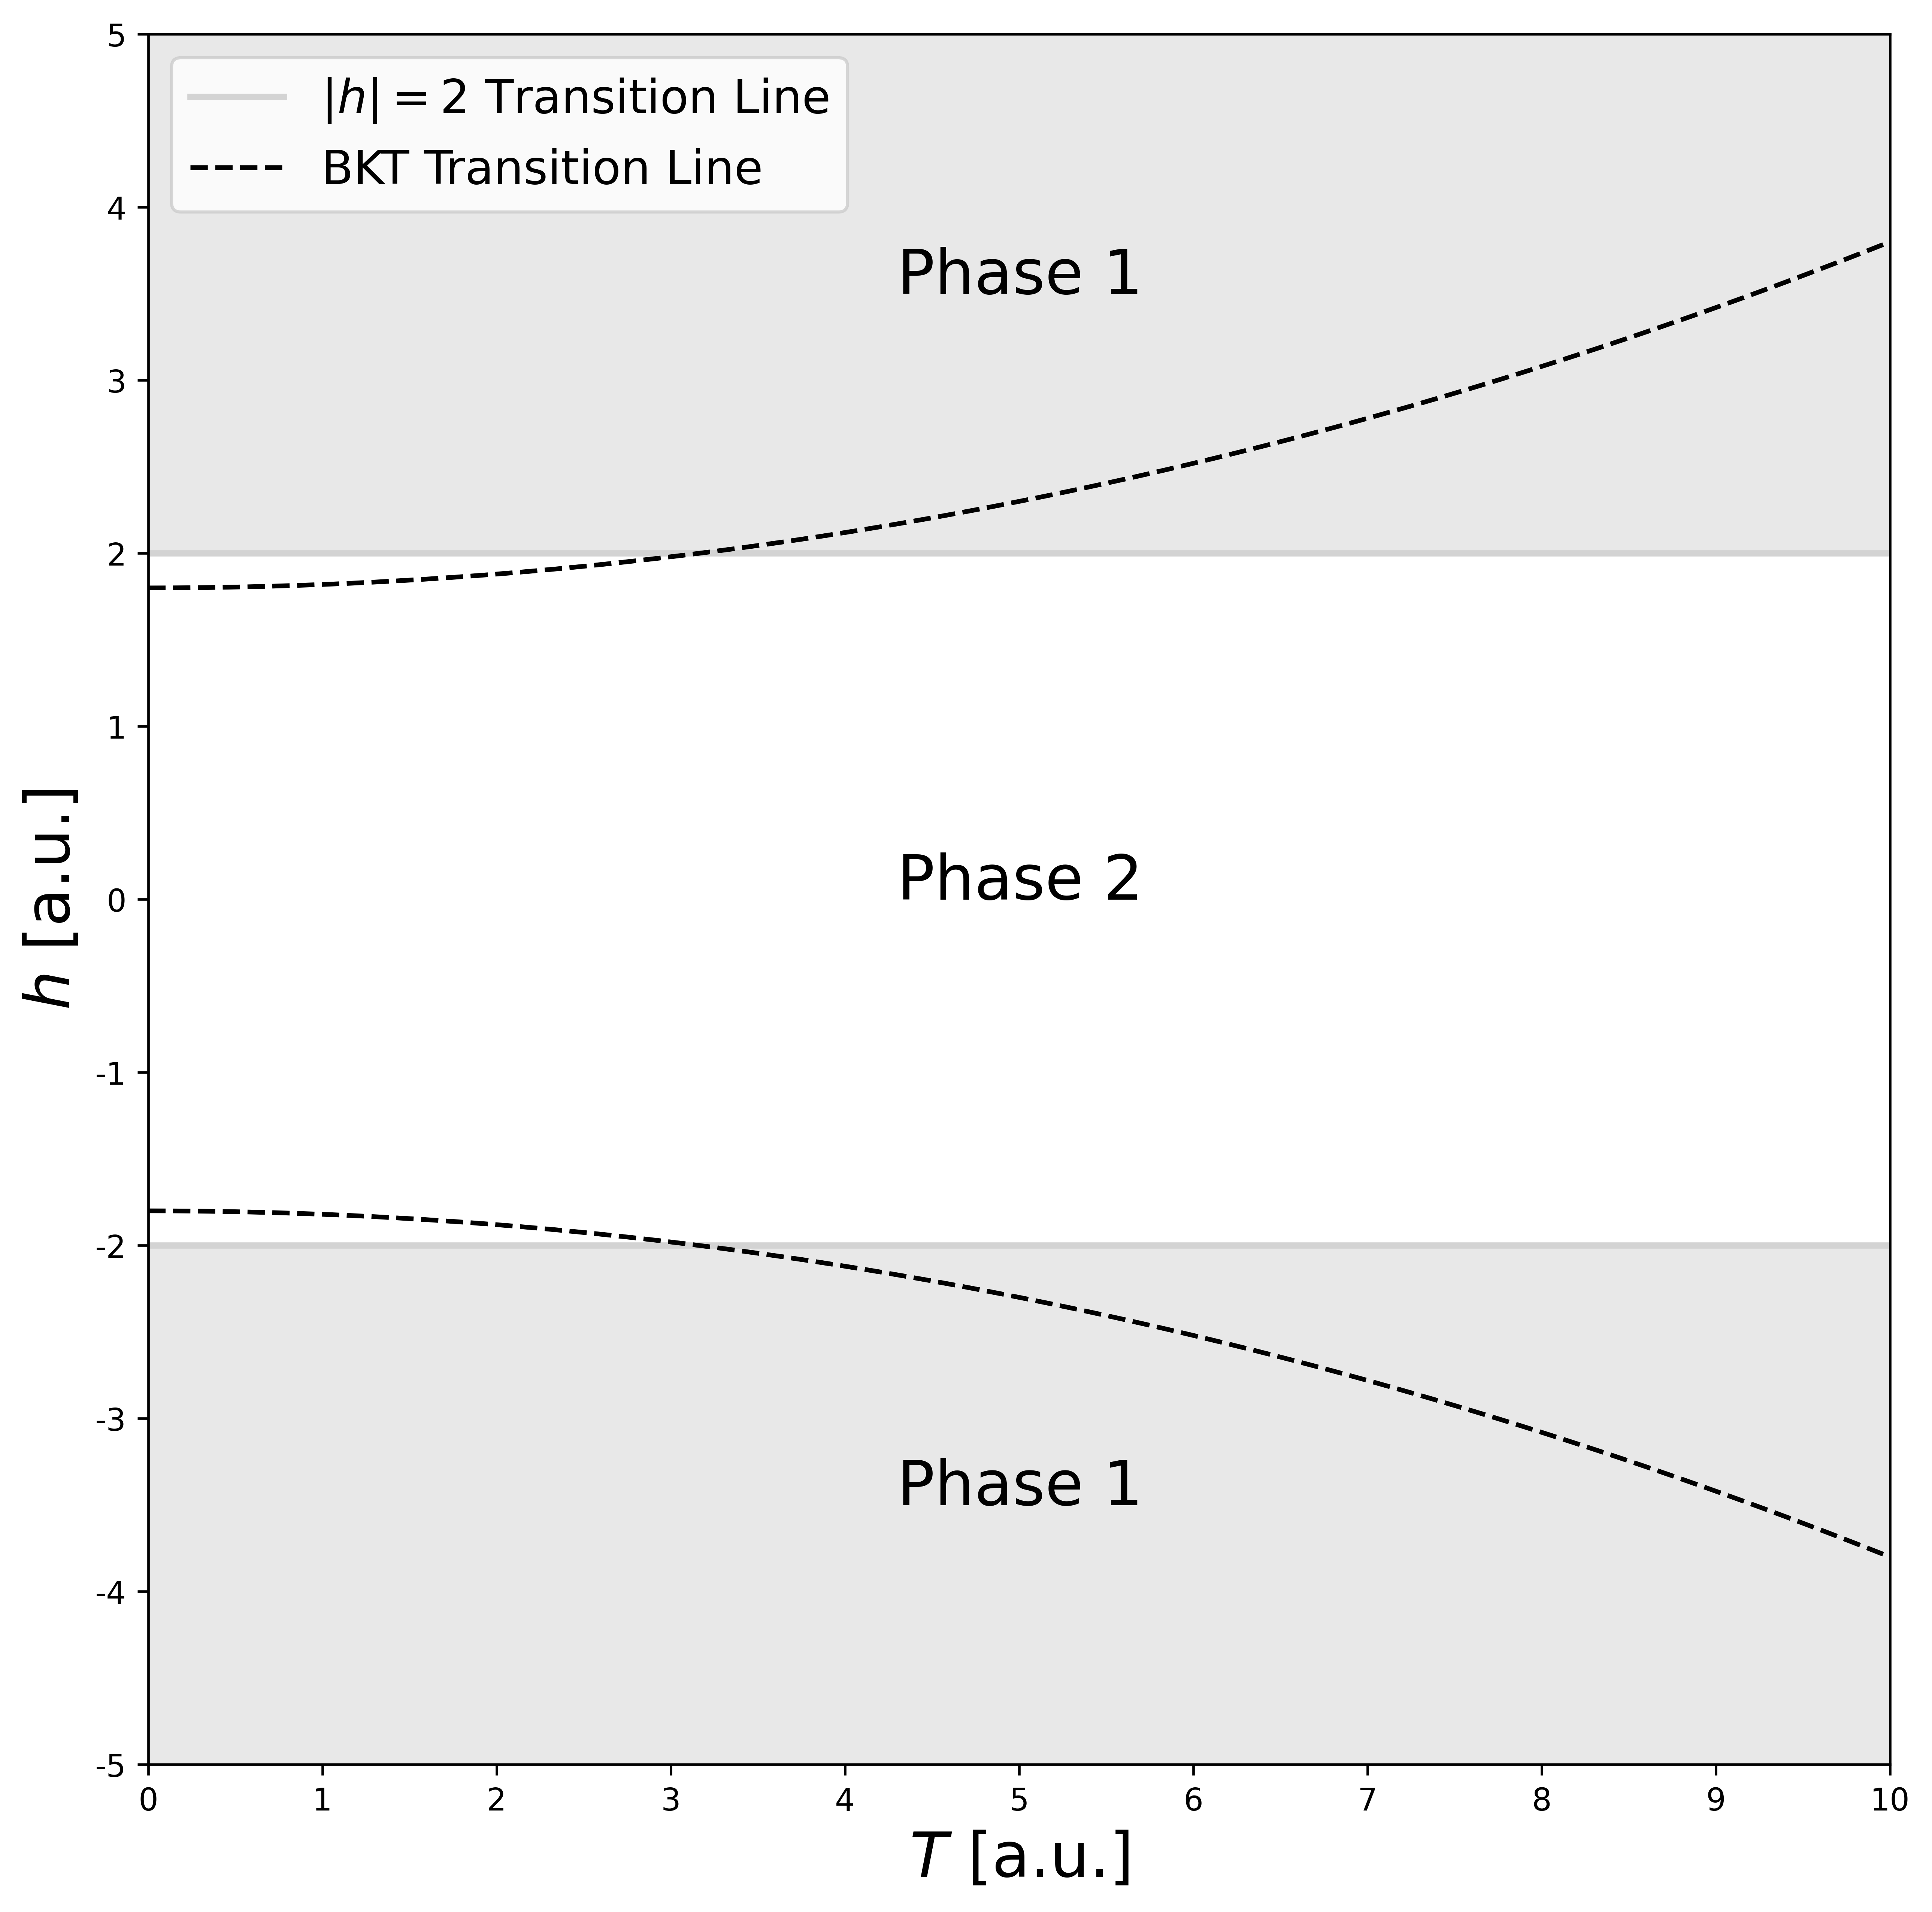

In [41]:
Image("C:/Users/user/Desktop/SQRT/2023 QHack/Phase Diagram.png")

We have obtained the energy curve, the specific heat curve, the magnetization curve for 10-qubit system too like:

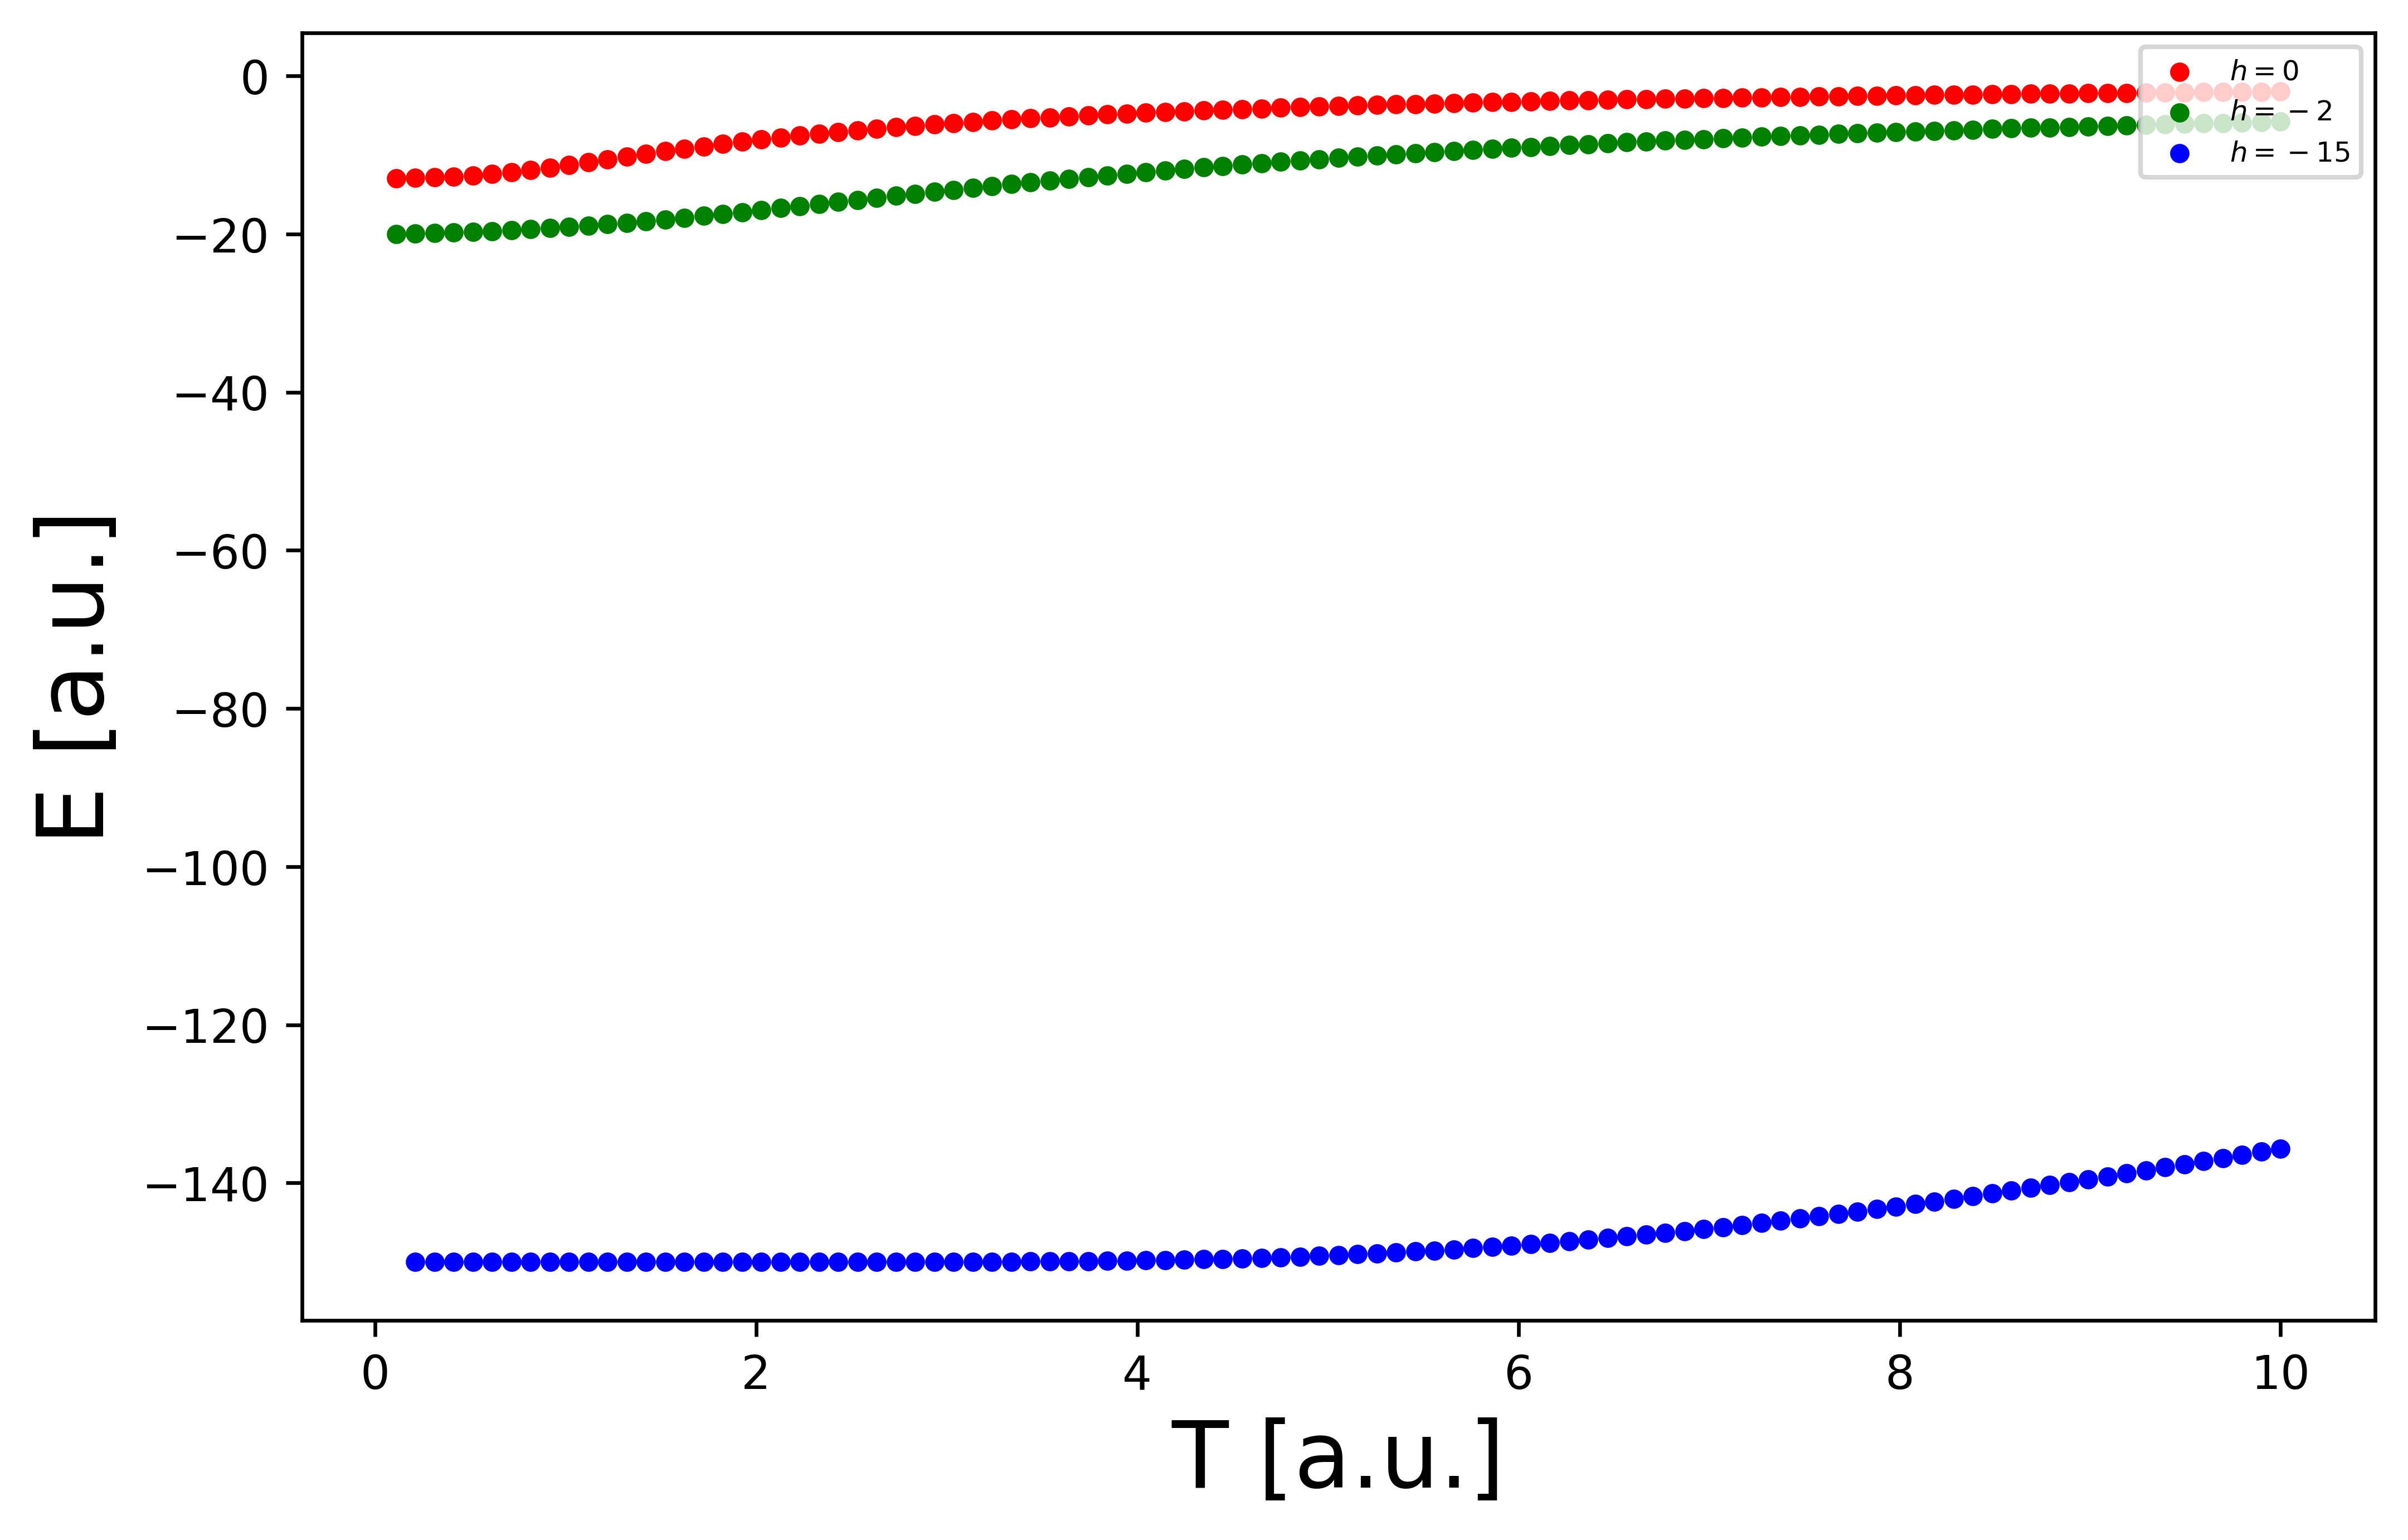

In [42]:
Image("C:/Users/user/Desktop/SQRT/2023 QHack/Energy Curve (10-qubit).png")

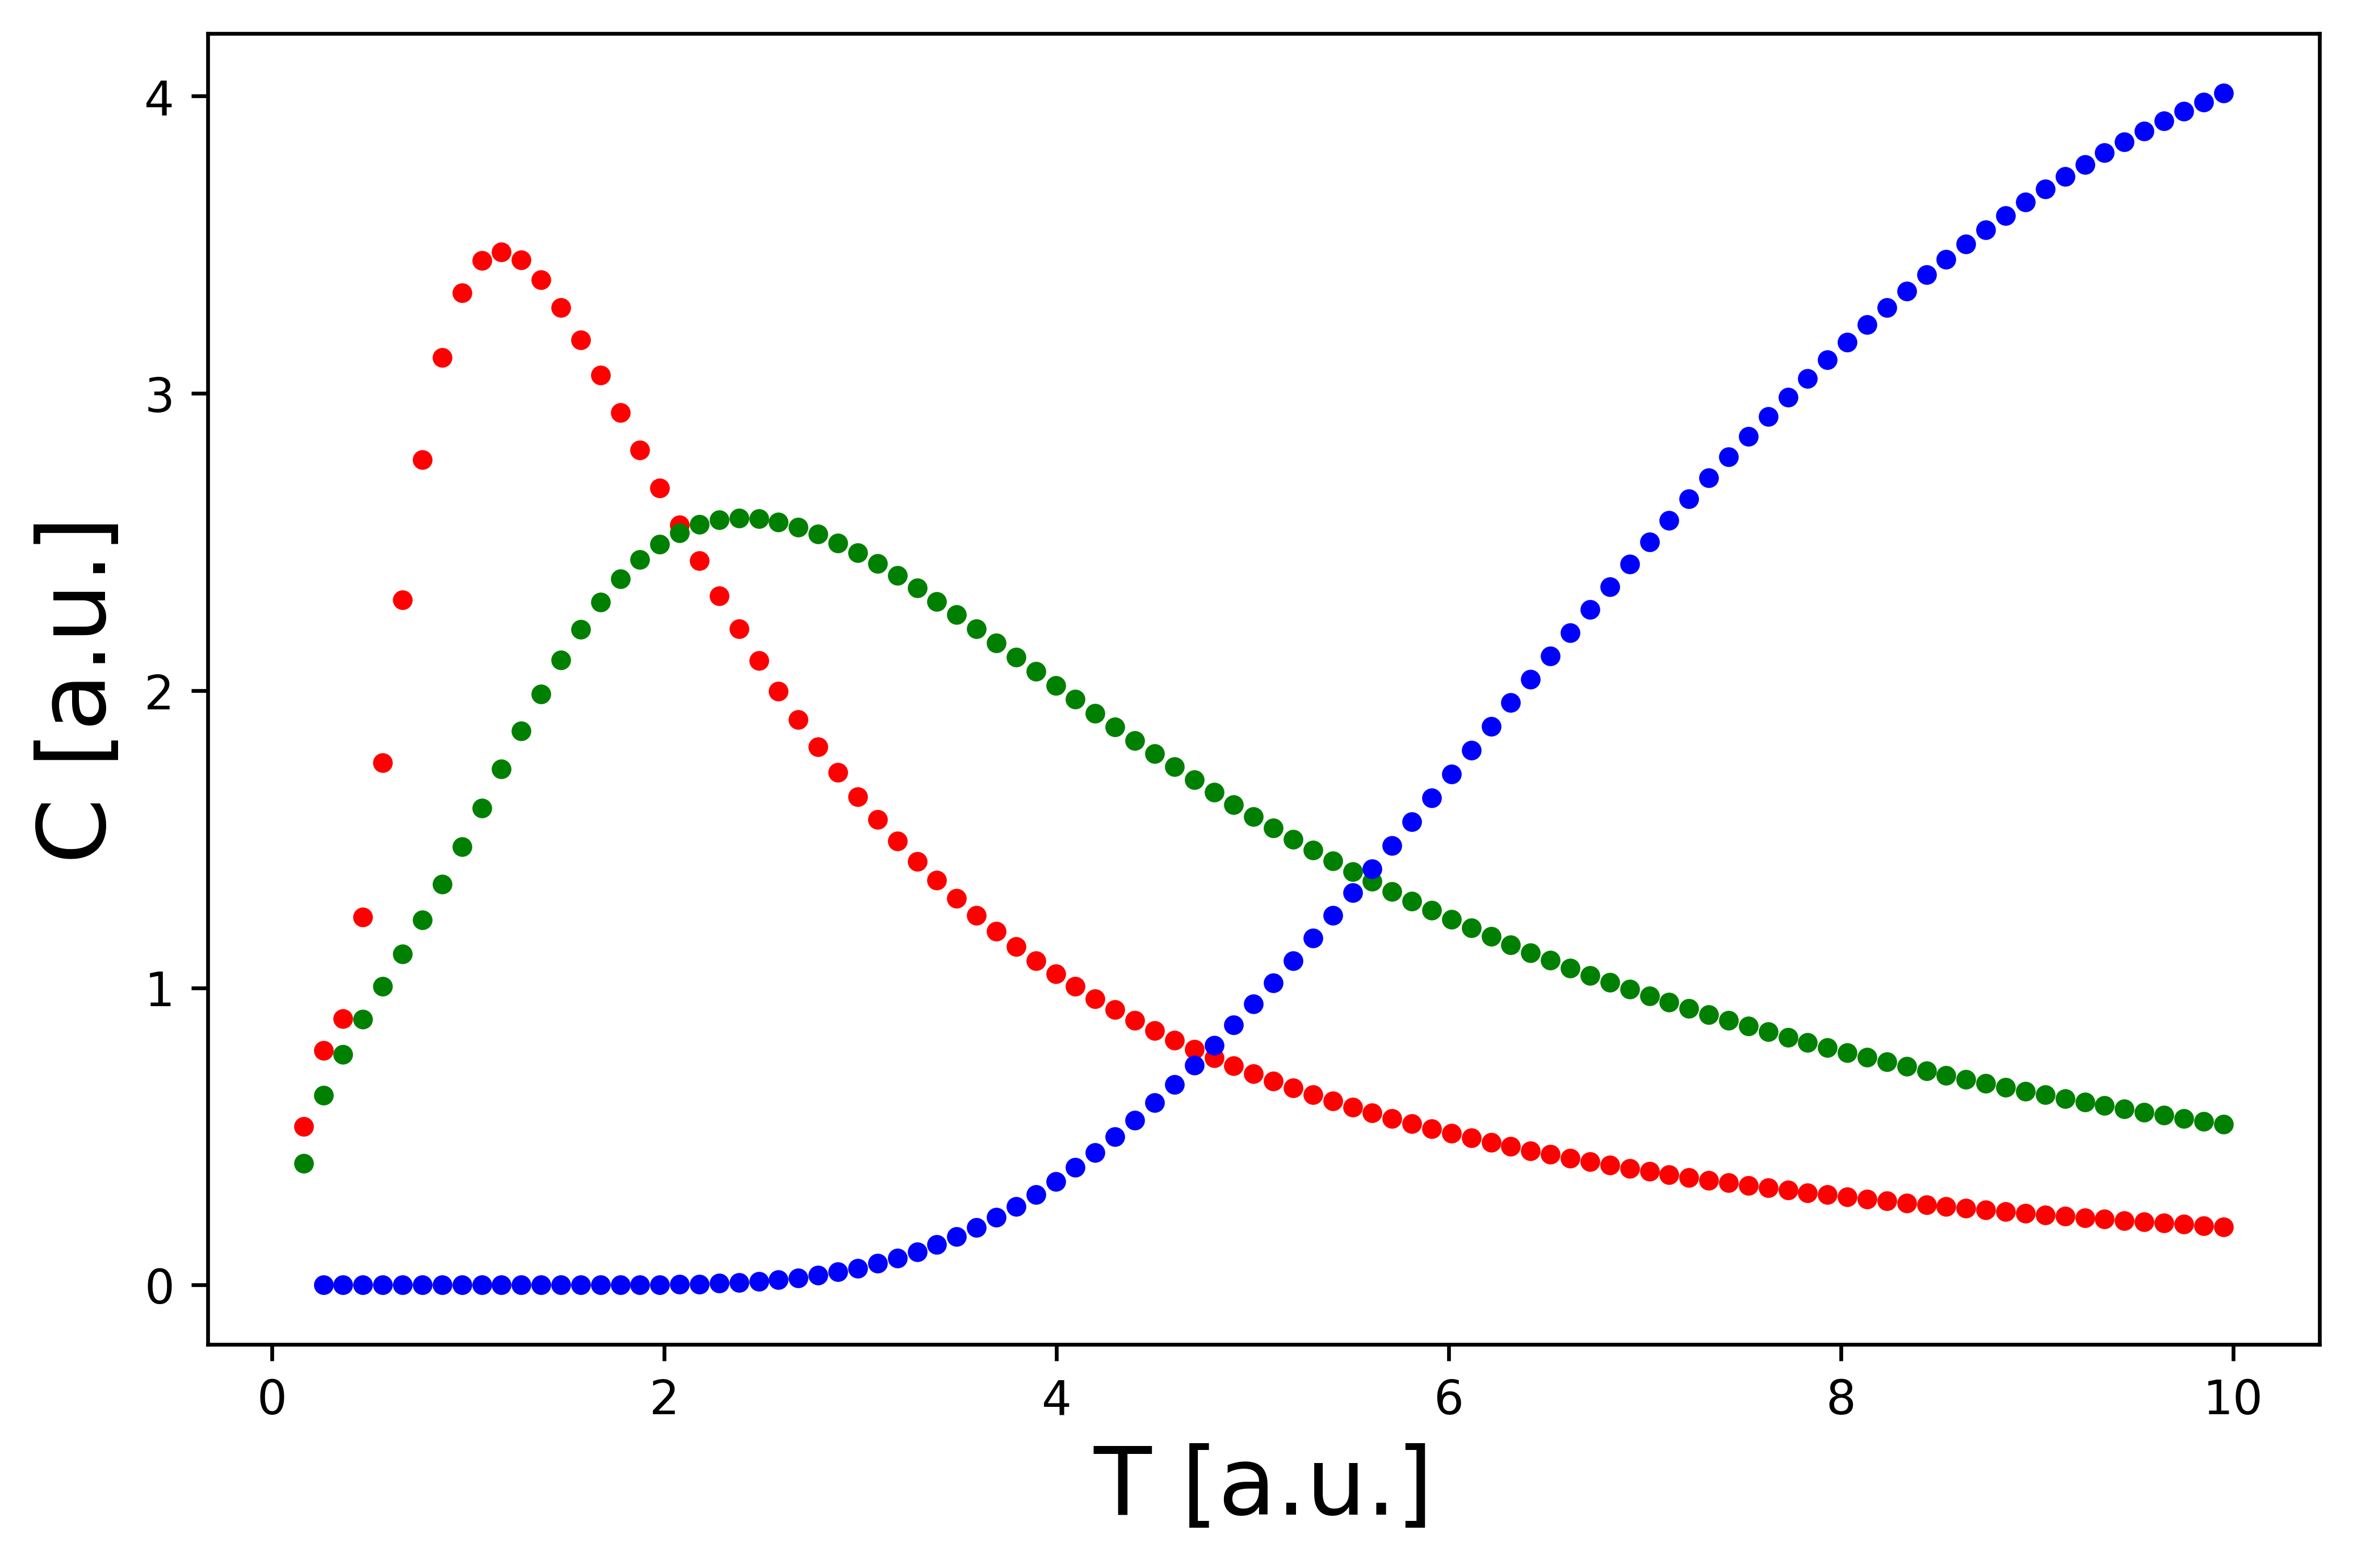

In [43]:
Image("C:/Users/user/Desktop/SQRT/2023 QHack/Specific Heat Curve (10-qubit).png")

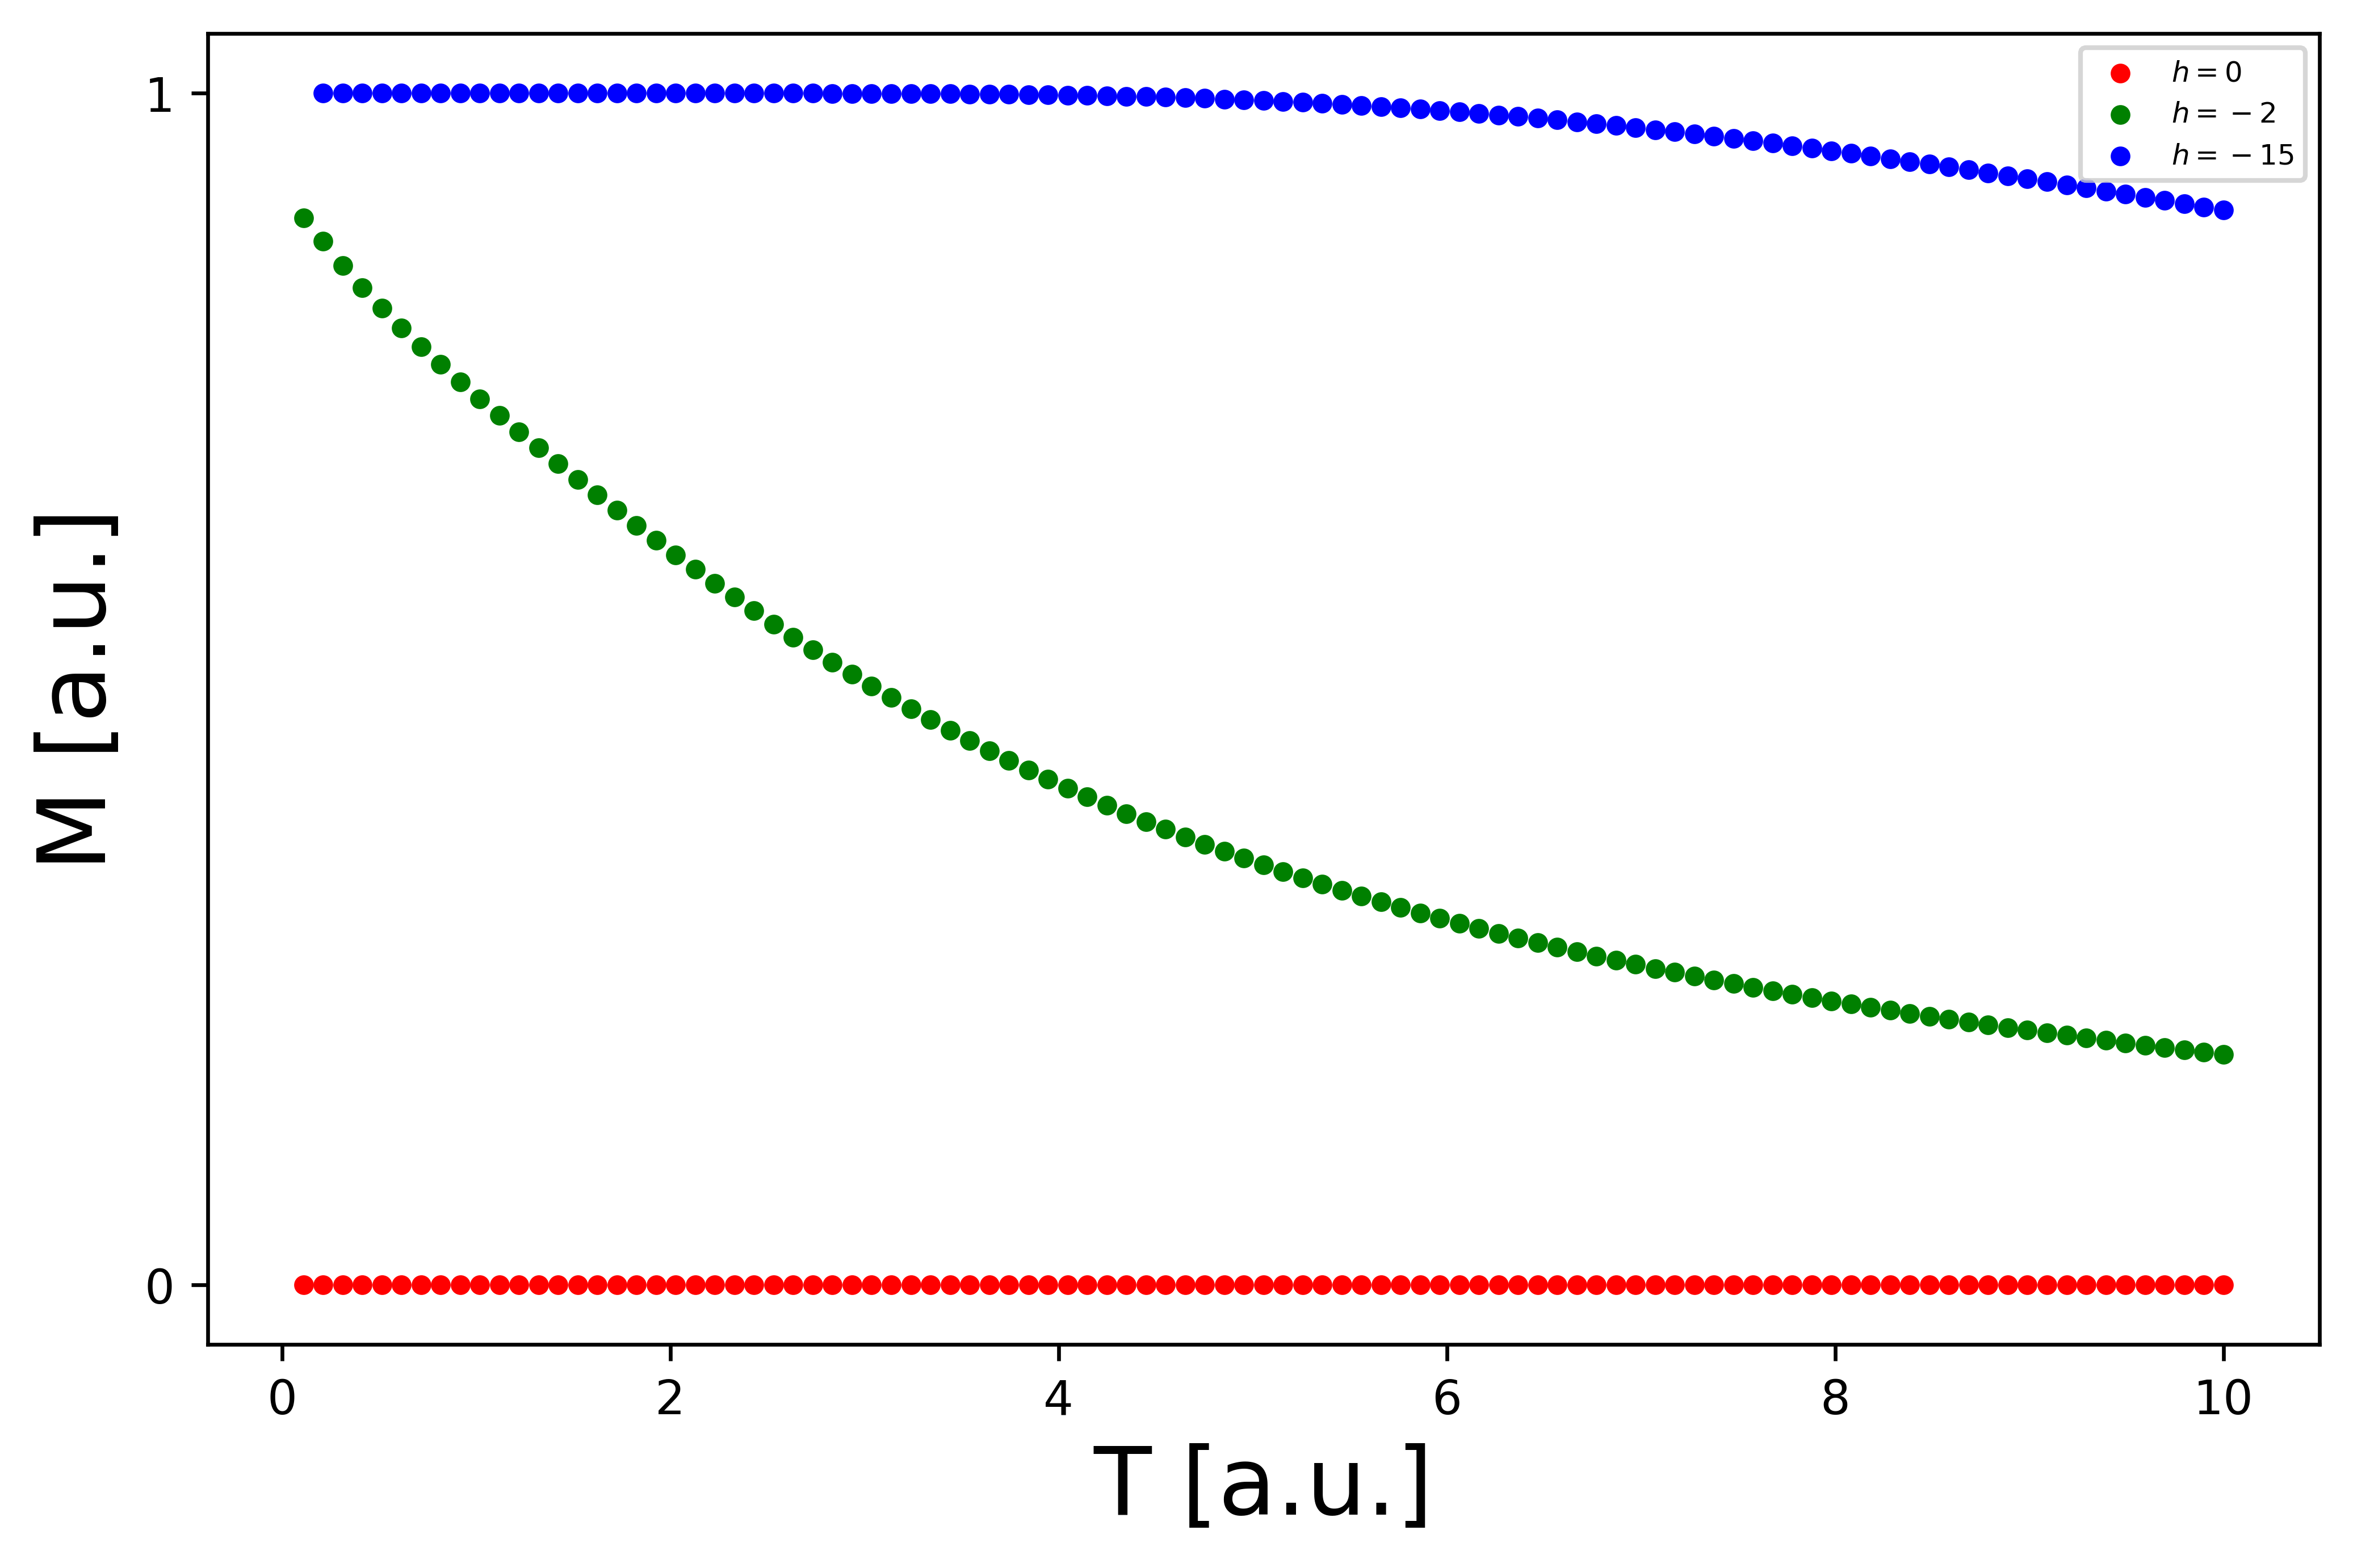

In [44]:
Image("C:/Users/user/Desktop/SQRT/2023 QHack/Magnetization Curve (10-qubit).png")

But, as you can see, the result was not that different from that of 4-qubit system. This indicates that for the analysis, 4-qubit system is sufficient.

### References

[1] León Boyajian, Walter, and Barbara Kraus. "Compressed simulation of thermal and excited states of the 1-D XY-model." arXiv e-prints (2015): arXiv-1506.

[2] Rogiers, Joseph, and M. Tachiki. "Spin ordering in spin-pair systems: The XY model in an external field." Physica A: Statistical Mechanics and its Applications 87.3 (1977): 614-622.

[3] Song, Feng-Feng, and Guang-Ming Zhang. "Hybrid Berezinskii-Kosterlitz-Thouless and Ising topological phase transition in the generalized two-dimensional XY model using tensor networks." Physical Review B 103.2 (2021): 024518.